In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, LayerNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.regularizers import l2

# -------------------- 1. Load and preprocess signals -------------------- #
def load_signals(subset="train"):
    signal_paths = [
        f"/content/drive/MyDrive/Colab Notebooks/Human activity rcognition/har_dataset/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt"
        for signal in [
            "total_acc_x", "total_acc_y", "total_acc_z",
            "body_acc_x", "body_acc_y", "body_acc_z",
            "body_gyro_x", "body_gyro_y", "body_gyro_z"
        ]
    ]
    signals = [np.loadtxt(path) for path in signal_paths]
    return np.transpose(np.array(signals), (1, 2, 0))

X_train = load_signals("train")
X_test = load_signals("test")

# Normalize the signals (L2 norm per sample)
X_train = X_train / np.linalg.norm(X_train, axis=(1, 2), keepdims=True)
X_test = X_test / np.linalg.norm(X_test, axis=(1, 2), keepdims=True)
#=======================================
y_train = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Human activity rcognition/har_dataset/UCI HAR Dataset/train/y_train.txt').astype(int) - 1
y_test = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Human activity rcognition/har_dataset/UCI HAR Dataset/test/y_test.txt').astype(int) - 1

# One-hot encode
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Class names
class_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

In [ ]:
# -------------------- 2. CNN + BiLSTM Model -------------------- #
model = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001),
           input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Bidirectional(LSTM(128)),  # Increased from 64 to 128 units
    LayerNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# -------------------- 3. Training Setup -------------------- #

# Optionally compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_har_model_v2.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train_cat,
    epochs=40,
    batch_size=64,
    validation_split=0.2,
    shuffle=True,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6417 - loss: 1.4631

92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.6428 - loss: 1.4590 - val_accuracy: 0.1795 - val_loss: 7.3249 - learning_rate: 0.0010
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.8981 - loss: 0.6527 - val_accuracy: 0.1795 - val_loss: 7.9522 - learning_rate: 0.0010
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - accuracy: 0.9515 - loss: 0.4780 - val_accuracy: 0.1795 - val_loss: 7.4462 - learning_rate: 0.0010
Epoch 4/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9444 - loss: 0.4671 - val_accuracy: 0.2699 - val_loss: 7.4943 - learning_rate: 0.0010
Epoch 5/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.9496 - loss: 0.4331 - val_accuracy: 0.2991 - val_loss: 7.3666 - learning_rate: 5.0000e-04
Epoch 6/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9548 - loss: 0.4152

92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.9548 - loss: 0.4152 - val_accuracy: 0.2284 - val_loss: 5.8248 - learning_rate: 5.0000e-04
Epoch 7/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9567 - loss: 0.3965

92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - accuracy: 0.9567 - loss: 0.3965 - val_accuracy: 0.5146 - val_loss: 2.8539 - learning_rate: 5.0000e-04
Epoch 8/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9596 - loss: 0.3777

92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.9596 - loss: 0.3778 - val_accuracy: 0.8933 - val_loss: 0.8227 - learning_rate: 5.0000e-04
Epoch 9/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9566 - loss: 0.3770

92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.9566 - loss: 0.3770 - val_accuracy: 0.8933 - val_loss: 0.7308 - learning_rate: 5.0000e-04
Epoch 10/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9532 - loss: 0.3661 - val_accuracy: 0.9069 - val_loss: 0.7598 - learning_rate: 5.0000e-04
Epoch 11/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.9614 - loss: 0.3468 - val_accuracy: 0.8810 - val_loss: 0.7419 - learning_rate: 5.0000e-04
Epoch 12/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9549 - loss: 0.3389 - val_accuracy: 0.8939 - val_loss: 0.7487 - learning_rate: 5.0000e-04
Epoch 13/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9571 - loss: 0.3270 - val_accuracy: 0.8973 - val_loss: 0.7784 - learning_rate: 2.5000e-04
Epoch 14/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.9605 - loss: 0.3151 - val_accuracy: 0.8810 - val_loss: 0.7383 - learning_rate: 2.5000e-04



✅ Test Accuracy: 91.04%


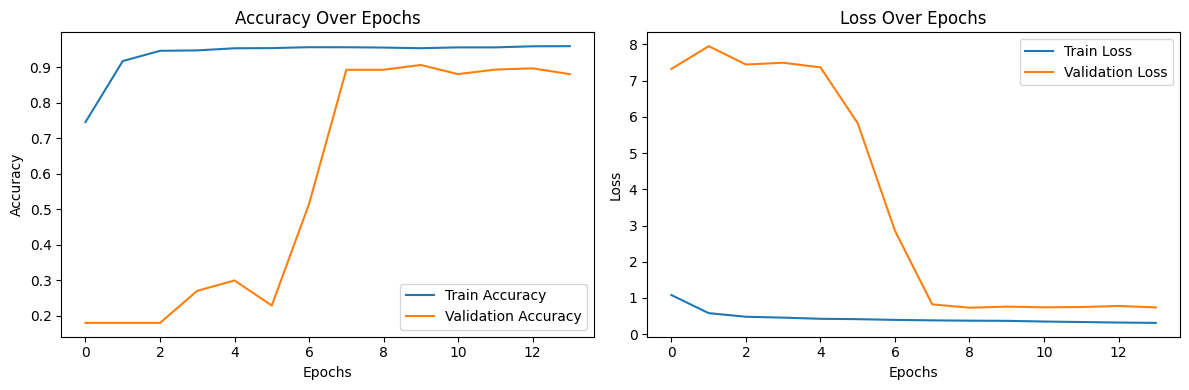

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


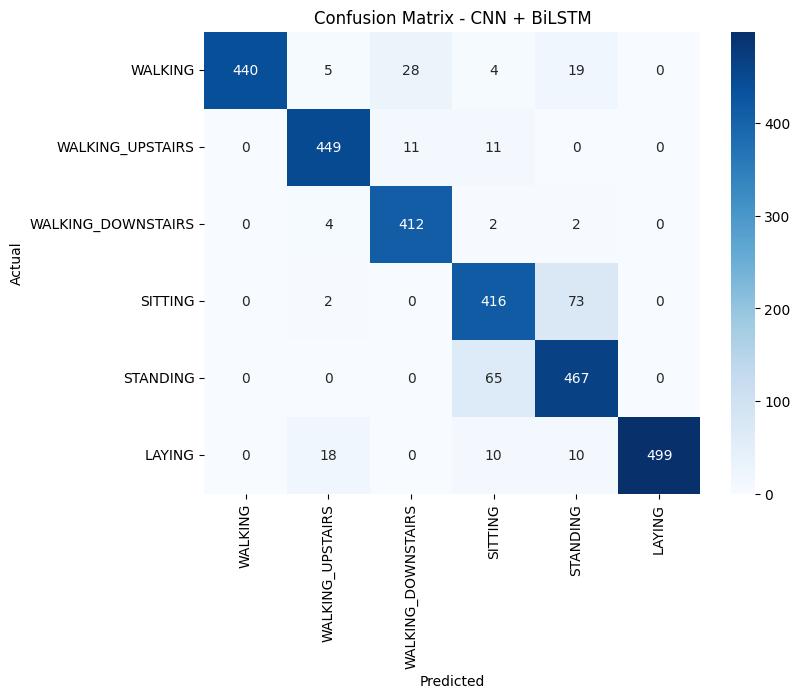


Classification Report:

                    precision    recall  f1-score   support

           WALKING       1.00      0.89      0.94       496
  WALKING_UPSTAIRS       0.94      0.95      0.95       471
WALKING_DOWNSTAIRS       0.91      0.98      0.95       420
           SITTING       0.82      0.85      0.83       491
          STANDING       0.82      0.88      0.85       532
            LAYING       1.00      0.93      0.96       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



In [ ]:
# -------------------- 4. Evaluate -------------------- #
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# -------------------- 5. Plot Learning Curves -------------------- #
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------- 6. Confusion Matrix -------------------- #
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN + BiLSTM')
plt.show()

# Classification report for insight on confusion
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

In [ ]:
# -------------------- 7. Show 20 Sample Predictions -------------------- #
print("\n🔍 20 Sample Predictions on Test Data:\n")
for i in range(20):
    sample_idx = np.random.randint(0, len(X_test))
    input_signal = X_test[sample_idx].reshape(1, 128, 9)
    true_label = class_names[y_test[sample_idx]]
    pred_label = class_names[np.argmax(model.predict(input_signal, verbose=0))]

    print(f"Sample {i+1:02d}:")
    print(f"🟢 Actual Activity   : {true_label}")
    print(f"🔵 Predicted Activity: {pred_label}")
    print("---")


🔍 20 Sample Predictions on Test Data:

Sample 01:
🟢 Actual Activity   : SITTING
🔵 Predicted Activity: SITTING
---
Sample 02:
🟢 Actual Activity   : SITTING
🔵 Predicted Activity: SITTING
---
Sample 03:
🟢 Actual Activity   : LAYING
🔵 Predicted Activity: LAYING
---
Sample 04:
🟢 Actual Activity   : WALKING_UPSTAIRS
🔵 Predicted Activity: WALKING_UPSTAIRS
---
Sample 05:
🟢 Actual Activity   : WALKING_UPSTAIRS
🔵 Predicted Activity: WALKING_DOWNSTAIRS
---
Sample 06:
🟢 Actual Activity   : LAYING
🔵 Predicted Activity: WALKING_UPSTAIRS
---
Sample 07:
🟢 Actual Activity   : STANDING
🔵 Predicted Activity: STANDING
---
Sample 08:
🟢 Actual Activity   : STANDING
🔵 Predicted Activity: STANDING
---
Sample 09:
🟢 Actual Activity   : WALKING
🔵 Predicted Activity: WALKING
---
Sample 10:
🟢 Actual Activity   : LAYING
🔵 Predicted Activity: LAYING
---
Sample 11:
🟢 Actual Activity   : WALKING_UPSTAIRS
🔵 Predicted Activity: WALKING_UPSTAIRS
---
Sample 12:
🟢 Actual Activity   : SITTING
🔵 Predicted Activity: SITTING


In [ ]:
model.save("final_har.h5")
print("✅ Model saved as final_har_model.h5")

✅ Model saved as final_har_model.h5
